<a href="https://colab.research.google.com/github/pagalavan-sivakumar/BitcoinPricePredictor/blob/main/BitcoinPricePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Libraires

In [337]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

from keras.layers import Dropout
from keras.layers import Dense


2. Importing Data

In [338]:
from google.colab import files
uploaded = files.upload()

Saving BTC-USD.csv to BTC-USD (15).csv


In [339]:
data = pd.read_csv (r'BTC-USD.csv')
data=data.dropna(0)
print (data)

            Date     Open     High      Low    Close  Adj Close         Volume
0     2014-09-17   465.86   468.17   452.42   457.33     457.33    21056800.00
1     2014-09-18   456.86   456.86   413.10   424.44     424.44    34483200.00
2     2014-09-19   424.10   427.83   384.53   394.80     394.80    37919700.00
3     2014-09-20   394.67   423.30   389.88   408.90     408.90    36863600.00
4     2014-09-21   408.08   412.43   393.18   398.82     398.82    26580100.00
...          ...      ...      ...      ...      ...        ...            ...
2632  2021-12-01 56907.96 59041.68 56553.08 57229.83   57229.83 36858195307.00
2633  2021-12-02 57217.37 57349.23 55895.13 56477.82   56477.82 32379968686.00
2634  2021-12-03 56509.16 57482.17 52496.59 53598.25   53598.25 39789134215.00
2635  2021-12-04 53727.88 53904.68 42874.62 49200.70   49200.70 61385677469.00
2636  2021-12-05 49408.49 49768.15 47862.82 48617.16   48617.16 39008100352.00

[2633 rows x 7 columns]


3. Split origianl data into training and testing data




In [340]:
data_training = data[data['Date']<'2021-01-01']
print (data_training)

            Date     Open     High      Low    Close  Adj Close         Volume
0     2014-09-17   465.86   468.17   452.42   457.33     457.33    21056800.00
1     2014-09-18   456.86   456.86   413.10   424.44     424.44    34483200.00
2     2014-09-19   424.10   427.83   384.53   394.80     394.80    37919700.00
3     2014-09-20   394.67   423.30   389.88   408.90     408.90    36863600.00
4     2014-09-21   408.08   412.43   393.18   398.82     398.82    26580100.00
...          ...      ...      ...      ...      ...        ...            ...
2293  2020-12-27 26439.37 28288.84 25922.77 26272.29   26272.29 66479895605.00
2294  2020-12-28 26280.82 27389.11 26207.64 27084.81   27084.81 49056742893.00
2295  2020-12-29 27081.81 27370.72 25987.30 27362.44   27362.44 45265946774.00
2296  2020-12-30 27360.09 28937.74 27360.09 28840.95   28840.95 51287442704.00
2297  2020-12-31 28841.57 29244.88 28201.99 29001.72   29001.72 46754964848.00

[2294 rows x 7 columns]


In [341]:
data_test=  data[data['Date']>='2021-01-01'].copy()
print (data_test)

            Date     Open     High      Low    Close  Adj Close         Volume
2298  2021-01-01 28994.01 29600.63 28803.59 29374.15   29374.15 40730301359.00
2299  2021-01-02 29376.46 33155.12 29091.18 32127.27   32127.27 67865420765.00
2300  2021-01-03 32129.41 34608.56 32052.32 32782.02   32782.02 78665235202.00
2301  2021-01-04 32810.95 33440.22 28722.76 31971.91   31971.91 81163475344.00
2302  2021-01-05 31977.04 34437.59 30221.19 33992.43   33992.43 67547324782.00
...          ...      ...      ...      ...      ...        ...            ...
2632  2021-12-01 56907.96 59041.68 56553.08 57229.83   57229.83 36858195307.00
2633  2021-12-02 57217.37 57349.23 55895.13 56477.82   56477.82 32379968686.00
2634  2021-12-03 56509.16 57482.17 52496.59 53598.25   53598.25 39789134215.00
2635  2021-12-04 53727.88 53904.68 42874.62 49200.70   49200.70 61385677469.00
2636  2021-12-05 49408.49 49768.15 47862.82 48617.16   48617.16 39008100352.00

[339 rows x 7 columns]


4) Drop irrelavant data for the neural network

In [342]:
training_data= data_training.drop(['Date', 'Adj Close'], axis = 1)
training_data.head()

,Open,High,Low,Close,Volume
0,465.86,468.17,452.42,457.33,21056800.00
1,456.86,456.86,413.10,424.44,34483200.00
2,424.10,427.83,384.53,394.80,37919700.00
3,394.67,423.30,389.88,408.90,36863600.00
4,408.08,412.43,393.18,398.82,26580100.00


In [343]:
testing_data= data_test.drop(['Date','Adj Close'], axis= 1)
testing_data.head()

,Open,High,Low,Close,Volume
2298,28994.01,29600.63,28803.59,29374.15,40730301359.00
2299,29376.46,33155.12,29091.18,32127.27,67865420765.00
2300,32129.41,34608.56,32052.32,32782.02,78665235202.00
2301,32810.95,33440.22,28722.76,31971.91,81163475344.00
2302,31977.04,34437.59,30221.19,33992.43,67547324782.00


In [345]:
scaler = MinMaxScaler(feature_range=(0,1))
training_data = scaler.fit_transform(training_data)


In [347]:
scaler = MinMaxScaler(feature_range=(0,1))
testing_data = scaler.fit_transform(testing_data)


5) Create X and Y training lists and add data into the list

In [348]:
X_train= []
y_train= []

In [349]:
X_test= []
y_test=[]


In [350]:
print(training_data.shape[0])

2294


In [351]:
print(testing_data.shape[0])

339


In [352]:
for i in range(60, training_data.shape[0]):
  X_train.append(training_data[i-60:i])# Append the all the values for every 59 days
  y_train.append(training_data[i,0]) # Append all the opening values for every day



In [353]:
for i in range(60, testing_data.shape[0]):
  X_test.append(testing_data[i-60:i])# Append the all the values for every 59 days
  y_test.append(testing_data[i,0]) # Append all the opening values for every day

6) Convert Lists into Arrays

In [354]:
X_train= np.array(X_train)
y_train= np.array(y_train)

In [355]:
X_test= np.array(X_test)
y_test= np.array(y_test)

In [356]:
print(X_train.shape)
print(y_train.shape)


(2234, 60, 5)
(2234,)


7) Create LSTM MODEL

In [357]:
additional_metrics = ['accuracy']

8)Define LSTM Model

In [358]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1],5),return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(60, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

9) Prepare to compile your model by adding the proper functions

In [359]:
model.compile(loss="mean_squared_error", optimizer="adam")

In [360]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 60, 50)            11200     
                                                                 
 dropout_44 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_45 (LSTM)              (None, 60, 60)            26640     
                                                                 
 dropout_45 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_46 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_46 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_47 (LSTM)              (None, 120)             

In [361]:
history = model.fit(X_train, y_train, batch_size=60, epochs=10,validation_split=0.20)

Epoch 1/10
30/30 [==============================] - 14s 293ms/step - loss: 0.0098 - val_loss: 0.0037
Epoch 2/10
30/30 [==============================] - 8s 270ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 3/10
30/30 [==============================] - 8s 270ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 4/10
30/30 [==============================] - 8s 268ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 5/10
30/30 [==============================] - 8s 269ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 6/10
30/30 [==============================] - 8s 269ms/step - loss: 9.0114e-04 - val_loss: 0.0029
Epoch 7/10
30/30 [==============================] - 8s 269ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 8/10
30/30 [==============================] - 8s 268ms/step - loss: 9.5142e-04 - val_loss: 0.0027
Epoch 9/10
30/30 [==============================] - 8s 270ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 10/10
30/30 [==============================] - 8s 267ms/step - loss: 9.0248e-04 - val

In [362]:
test_results = model.evaluate(X_train, y_train, verbose=False)



In [363]:
print( test_results)

0.0009393083746545017


In [364]:
y_prediction= model.predict(X_test, verbose=False) 

In [365]:
scale=1/2.59364857e-05

In [366]:
y_prediction= scale*y_prediction

In [367]:
y_test= scale*y_test

KeyError: ignored

In [ ]:
#np.set_printoptions(formatter={'float_kind':'{y_prediction:f}'.format})

In [ ]:
#np.set_printoptions(formatter={'float_kind':'{y_test:f}'.format})

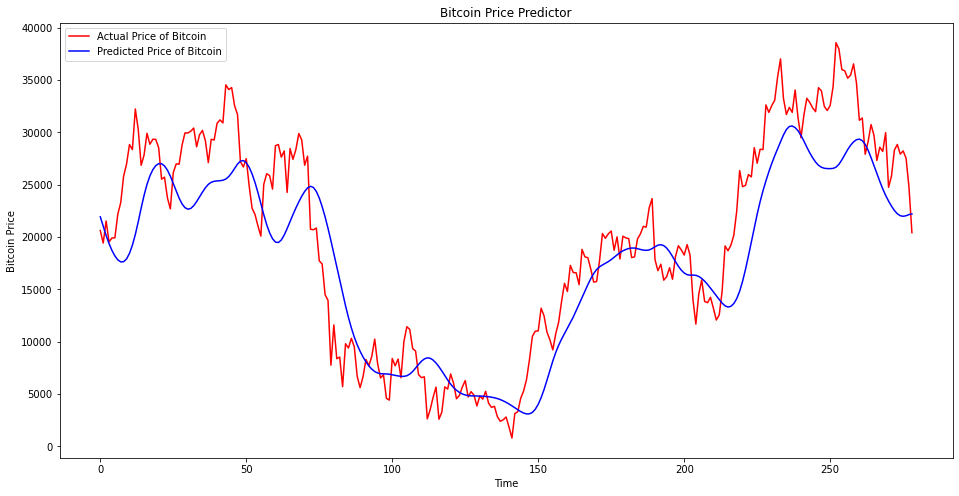

In [369]:

fig, ax = plt.subplots(figsize=(16,8))
ax.ticklabel_format(useOffset=False)
plt.plot(y_test, color='red', label= 'Actual Price of Bitcoin')
plt.plot(y_prediction, color='blue', label= 'Predicted Price of Bitcoin')
plt.title('Bitcoin Price Predictor')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()